# 02: Statistical Analysis & Causal Inference

This notebook performs rigorous statistical testing on the QoE data.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from src.telecom_qoe_analytics.data_loader import get_merged_dataset, setup_plotting

setup_plotting(context="paper", palette="deep", style="ticks")
df = get_merged_dataset()

📈 Plotting environment set: style=ticks, palette=deep, context=paper


## 1. Hypothesis Testing: QoE by Segment

Testing if different user segments have significantly different QoE scores.

In [2]:
segments = df["segment"].unique()
groups = [df[df["segment"] == s]["qoe_score"].dropna() for s in segments]

# ANOVA
f_val, p_val = stats.f_oneway(*groups)
print(f"ANOVA F-value: {f_val:.2f}, p-value: {p_val:.2f}")


ANOVA F-value: 4.35, p-value: 0.01


### 💡 How to read this: ANOVA p-value (Analysis of Variance)
* **The Goal:** To see if different segments (e.g., Prepaid vs Postpaid) have the same QoE.
* **The p-value:** 
    * **< 0.05:** There is a statistically significant difference. It's not just luck; certain segments ARE having a worse time.
    * **> 0.05:** The segments perform roughly the same. Don't waste marketing budget on segment-specific fixes!


## 2. Cell Band Analysis

In [3]:
print("Distribution by Band:")
print(df["band"].value_counts())

Distribution by Band:
band
L1800    125420
L2300     60466
L2100     55343
L900      39546
Name: count, dtype: int64


## 3. Correlation Analysis

Correlation between KPIs and QoE Score.

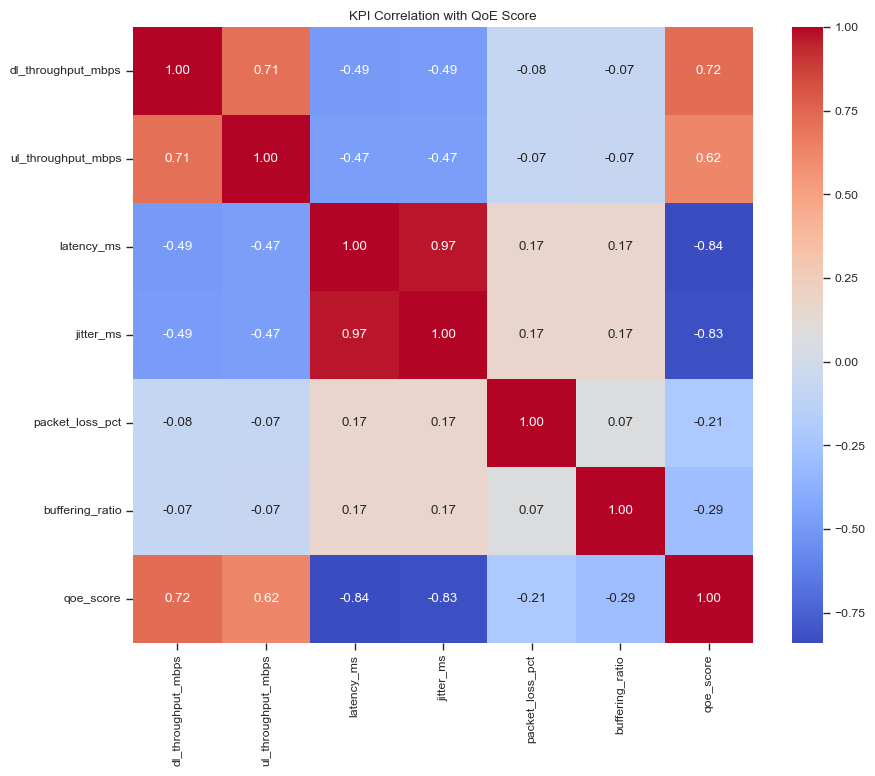

In [4]:
kpis = ["dl_throughput_mbps", "ul_throughput_mbps", "latency_ms", "jitter_ms", "packet_loss_pct", "buffering_ratio"]
corr_matrix = df[kpis + ["qoe_score"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("KPI Correlation with QoE Score")
plt.show()

### 💡 How to read this: Correlation Matrix
* **Colors:** Dark red (+1) means they move together. Dark blue (-1) means they move in opposite directions.
* **Insights:** 
    * If `latency_ms` has a strong negative correlation with `qoe_score`, it means "as latency goes UP, QoE goes DOWN."
    * Values near **0** mean there's no linear relationship. Don't use that KPI as a primary predictor!


## 4. Effect Size (Cohen's d)

Let's compare high vs low congestion QoE.

In [5]:
congested = df[df["congestion_flag"] == True]["qoe_score"]
non_congested = df[df["congestion_flag"] == False]["qoe_score"]

# Cohen's d
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d = cohen_d(congested, non_congested)
print(f"Cohen's d for Congestion effect on QoE: {d:.4f}")

Cohen's d for Congestion effect on QoE: -2.7517


Cohen's d is a measure of **effect size** used to indicate the standardized difference between two means. It helps us determine the practical significance of a result, rather than just its statistical significance.
* **Why not just the mean?** A p-value tells you if a difference is *real*, but Cohen's d tells you if it is *large enough to care*.
* **The Scale:** 
    * **0.2:** Small effect. 
    * **0.5:** Medium effect. 
    * **0.8+:** Large effect.
* **Action:** With a Cohen's d of -2.75, the effect size is extremely large. This confirms that congestion is a massive driver for QoE degradation—addressing it is critical.
